In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banana1/dataset/unripe/ur(357).jpg
/kaggle/input/banana1/dataset/unripe/ur(694).jpg
/kaggle/input/banana1/dataset/unripe/ur(278).jpg
/kaggle/input/banana1/dataset/unripe/ur(1340).jpg
/kaggle/input/banana1/dataset/unripe/ur(409).jpg
/kaggle/input/banana1/dataset/unripe/ur(608).jpg
/kaggle/input/banana1/dataset/unripe/ur(773).jpg
/kaggle/input/banana1/dataset/unripe/ur(515).jpg
/kaggle/input/banana1/dataset/unripe/ur(837).jpg
/kaggle/input/banana1/dataset/unripe/ur(1003).jpg
/kaggle/input/banana1/dataset/unripe/ur(1069).jpg
/kaggle/input/banana1/dataset/unripe/ur(869).jpg
/kaggle/input/banana1/dataset/unripe/ur(543).jpg
/kaggle/input/banana1/dataset/unripe/ur(1483).jpg
/kaggle/input/banana1/dataset/unripe/ur(1358).jpg
/kaggle/input/banana1/dataset/unripe/ur(314).jpg
/kaggle/input/banana1/dataset/unripe/ur(716).jpg
/kaggle/input/banana1/dataset/unripe/ur(1454).jpg
/kaggle/input/banana1/dataset/unripe/ur(5).jpg
/kaggle/input/banana1/dataset/unripe/ur(449).jpg
/kaggle/input/ba

In [6]:
!pip install split-folders

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os 
import glob as gb

from sklearn.model_selection import train_test_split

import timm 

import torch 
import torch.nn as nn 
from torch.optim import Adam , lr_scheduler 
from torch.utils.data import Dataset , DataLoader 
from torchinfo import summary 
import torchvision 
import torchvision.transforms as transforms
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


In [9]:
base_ds = '/kaggle/input/banana1/dataset'
base_ds = pathlib.Path(base_ds)
splitfolders.ratio(base_ds, output='banana image dataset', seed=123, ratio=(.8,.2), group_prefix=None)

Copying files: 4500 files [00:27, 166.15 files/s]


In [34]:
DATASET_DIR = '/kaggle/working/banana image dataset' 
MODEL_PATH = '/kaggle/input/vit122/jx_vit_base_p16_224-80ecf9dd.pth'

IMG_SIZE = 224 
BATCH_SIZE = 64
LR = 2e-05
EPOCHS = 10

In [11]:
classes = [] 
for folder in tqdm(os.listdir(DATASET_DIR)) : 
    for path in os.listdir(DATASET_DIR + "/" + folder) : 
        if path not in classes : 
            classes.append(path)

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
img_label={key : value for value , key in enumerate(classes)}
img_label

{'ripe': 0, 'unripe': 1, 'overripe': 2}

In [13]:
def getlabel(n) : 
    for x , y in img_label.items() : 
        if y==n : 
            return x

In [14]:
img_paths = [] 
labels = [] 
for folder in tqdm(os.listdir(DATASET_DIR)) : 
    for path in os.listdir(DATASET_DIR + "/" + folder) : 
        files = gb.glob(pathname = str(DATASET_DIR + "/" + folder + "/" + path + "/*.jpg")) 
        
        for file in files : 
            img_paths.append(file) 
            labels.append(img_label[path]) 
            
img_paths = np.array(img_paths) 
labels = np.array(labels) 

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
train_paths , val_paths , train_labels , val_labels = train_test_split(img_paths , labels , train_size = 0.80 , random_state = 42) 

In [16]:
print(f"The size of the training set is : {len(train_paths)}")
print(f"The size of the validation set is : {len(val_paths)}")

The size of the training set is : 3469
The size of the validation set is : 868


In [17]:
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [18]:
class CustomData(Dataset) : 
    def __init__(self , img_paths , labels) : 
        self.img_paths = img_paths 
        self.labels = labels 
        
        self.transform = transforms.Compose([
            transforms.Resize(size = (IMG_SIZE , IMG_SIZE)) , 
            transforms.ToTensor() 
        ])
        
        if len(self.img_paths) != len(self.labels) : 
            raise InvalidDatasetException(self.img_paths , self.labels)
            
    def __len__(self) : 
        return len(self.img_paths)
    
    
    def __getitem__(self , idx) : 
        img = Image.fromarray(cv2.cvtColor(cv2.imread(self.img_paths[idx]) , cv2.COLOR_BGR2RGB)) 
        img = self.transform(img)
        
        label = torch.tensor(self.labels[idx]) 
        
        return img , label 

In [19]:
train_set = CustomData(train_paths , train_labels) 
val_set = CustomData(val_paths , val_labels) 

In [20]:
torch.manual_seed(42) 
train_dataloader = DataLoader(
    dataset = train_set , 
    batch_size = BATCH_SIZE , 
    shuffle = True , 
    num_workers = 4 , 
    pin_memory = True
)

torch.manual_seed(42) 
val_dataloader = DataLoader(
    dataset = val_set , 
    batch_size = BATCH_SIZE , 
    shuffle = False , 
    num_workers = 4 , 
    pin_memory = True
)

In [21]:
print(f"the size of the train dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

print(f"the size of the validation dataloader {len(val_dataloader)} batches of {BATCH_SIZE}")

the size of the train dataloader 55 batches of 64
the size of the validation dataloader 14 batches of 64


In [22]:
img_sample , label_sample = next(iter(train_dataloader)) 
img_sample.shape , label_sample.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

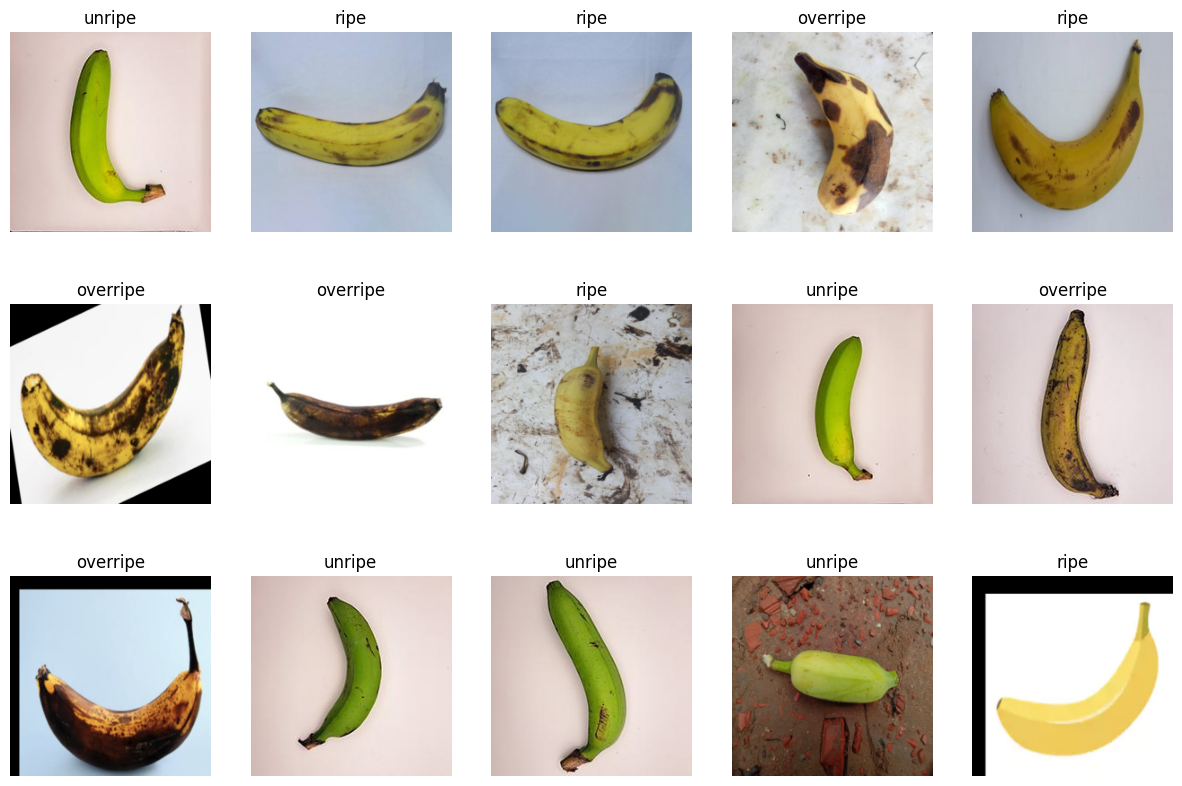

In [23]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad(): 
        img = np.transpose(img_sample[i].numpy(), (1, 2, 0))
        ax.imshow(img)
        ax.set(title = f"{getlabel(label_sample[i])}")
        ax.axis('off')

In [24]:
N_CLASSES = len(img_label)
N_CLASSES

3

In [31]:
class VitBase16(nn.Module) : 
    def __init__(self , n_classes , pretrained = False) : 
        
        super(VitBase16 , self).__init__() 
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH)) 
            
        self.model.head = nn.Linear(self.model.head.in_features , n_classes) 
        
    def forward(self , x) : 
        out  =self.model(x) 
        
        return out 


In [32]:
model = VitBase16(N_CLASSES , pretrained=True).to(DEVICE) 

In [33]:
summary(model , input_size=(BATCH_SIZE , 3 , IMG_SIZE , IMG_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
VitBase16                                     [64, 3]                   --
├─VisionTransformer: 1-1                      [64, 3]                   152,064
│    └─PatchEmbed: 2-1                        [64, 196, 768]            --
│    │    └─Conv2d: 3-1                       [64, 768, 14, 14]         590,592
│    │    └─Identity: 3-2                     [64, 196, 768]            --
│    └─Dropout: 2-2                           [64, 197, 768]            --
│    └─Identity: 2-3                          [64, 197, 768]            --
│    └─Identity: 2-4                          [64, 197, 768]            --
│    └─Sequential: 2-5                        [64, 197, 768]            --
│    │    └─Block: 3-3                        [64, 197, 768]            7,087,872
│    │    └─Block: 3-4                        [64, 197, 768]            7,087,872
│    │    └─Block: 3-5                        [64, 197, 768]           

In [35]:
criterion = nn.CrossEntropyLoss() 
optimizer = Adam(model.parameters(), lr=LR)
train_losses = [] 
train_accuracies = []  
val_losses = [] 
val_accuracies = [] 

for epoch in tqdm(range(EPOCHS)) : 
    epoch_train_loss = 0 
    train_correct=0
    train_total=0
    
    epoch_val_loss = 0 
    val_correct=0
    val_total=0
    
    model.train() 
    for img , label in train_dataloader : 
        img , label = img.to(DEVICE) , label.to(DEVICE) 
        
        output = model(img) 
        
        loss = criterion(output , label.long())
        
        epoch_train_loss += loss.item()
        
        _,pred = torch.max(output,dim=1)
        train_correct = train_correct + torch.sum(pred == label).item()
        train_total += label.size(0) 
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
        
    model.eval() 
    with torch.no_grad() : 
        for img , label in val_dataloader : 
            img , label = img.to(DEVICE) , label.to(DEVICE) 
        
            output = model(img) 
        
            loss = criterion(output , label.long()) 
            
            epoch_val_loss += loss.item()
            
            _,pred = torch.max(output,dim=1)
            val_correct = val_correct + torch.sum(pred == label).item()
            val_total += label.size(0)
            
            
    train_losses.append((epoch_train_loss / len(train_dataloader)))
    train_accuracies.append((100 * train_correct / train_total))
    
    val_losses.append((epoch_val_loss / len(val_dataloader)))
    val_accuracies.append((100 * val_correct / val_total))
    
    print(f"[Epoch {epoch+1}/{EPOCHS}] [Train Loss: {train_losses[-1]:0.2f}] [Train Accuracy: {train_accuracies[-1]:0.2f}%]\n[Validation Loss: {val_losses[-1]:0.2f}] [Validation Accuracy: {val_accuracies[-1]:0.2f}%]\n")

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1/10] [Train Loss: 0.25] [Train Accuracy: 93.02%]
[Validation Loss: 0.04] [Validation Accuracy: 98.62%]

[Epoch 2/10] [Train Loss: 0.03] [Train Accuracy: 99.37%]
[Validation Loss: 0.03] [Validation Accuracy: 98.85%]

[Epoch 3/10] [Train Loss: 0.02] [Train Accuracy: 99.48%]
[Validation Loss: 0.04] [Validation Accuracy: 98.85%]

[Epoch 4/10] [Train Loss: 0.01] [Train Accuracy: 99.83%]
[Validation Loss: 0.04] [Validation Accuracy: 98.85%]

[Epoch 5/10] [Train Loss: 0.00] [Train Accuracy: 100.00%]
[Validation Loss: 0.03] [Validation Accuracy: 98.85%]

[Epoch 6/10] [Train Loss: 0.00] [Train Accuracy: 100.00%]
[Validation Loss: 0.04] [Validation Accuracy: 98.85%]

[Epoch 7/10] [Train Loss: 0.00] [Train Accuracy: 100.00%]
[Validation Loss: 0.03] [Validation Accuracy: 98.73%]

[Epoch 8/10] [Train Loss: 0.00] [Train Accuracy: 100.00%]
[Validation Loss: 0.04] [Validation Accuracy: 98.85%]

[Epoch 9/10] [Train Loss: 0.00] [Train Accuracy: 100.00%]
[Validation Loss: 0.04] [Validation Accura

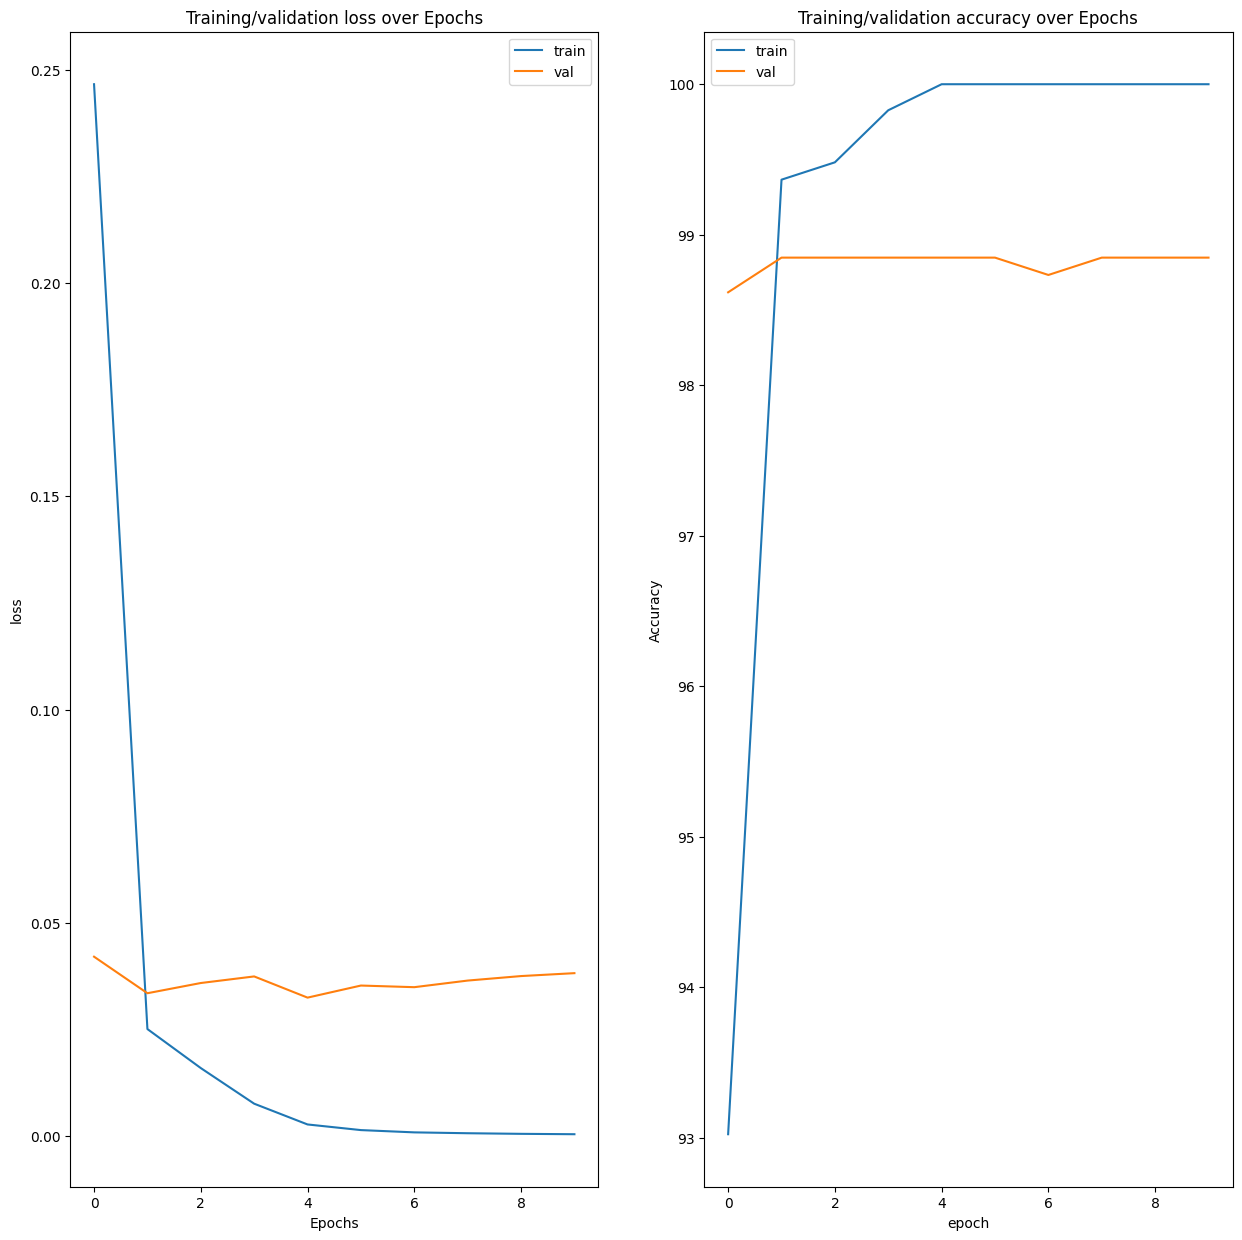

In [39]:
figure , axis = plt.subplots(1,2,figsize=(15,15))

axis[0].plot(train_losses , label='train')
axis[0].plot(val_losses , label='val')
axis[0].set_title('Training/validation loss over Epochs')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('loss')
axis[0].legend()

axis[1].plot(train_accuracies, label='train')
axis[1].plot(val_accuracies, label='val')
axis[1].set_title('Training/validation accuracy over Epochs')
axis[1].set_xlabel('epoch')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

In [40]:
print(f"The loss of the training set is : {train_losses[-1]:0.3f}")
print(f"The accuracy of the training set is : {train_accuracies[-1]:0.3f}%")

The loss of the training set is : 0.000
The accuracy of the training set is : 100.000%


In [41]:
print(f"The loss of the Validation set is : {val_losses[-1]:0.3f}")
print(f"The accuracy of the Validation set is : {val_accuracies[-1]:0.3f}%")

The loss of the Validation set is : 0.038
The accuracy of the Validation set is : 98.848%


In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure model is in evaluation mode
model.eval()

true_labels = []
predictions = []

# No gradient calculation is needed
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for sklearn functions
true_labels = np.array(true_labels)
predictions = np.array(predictions)


In [45]:
class_names={'ripe': 0, 'unripe': 1, 'overripe': 2}

Classification Report:
               precision    recall  f1-score   support

        ripe       0.98      0.99      0.98       302
      unripe       1.00      1.00      1.00       285
    overripe       0.99      0.98      0.98       281

    accuracy                           0.99       868
   macro avg       0.99      0.99      0.99       868
weighted avg       0.99      0.99      0.99       868



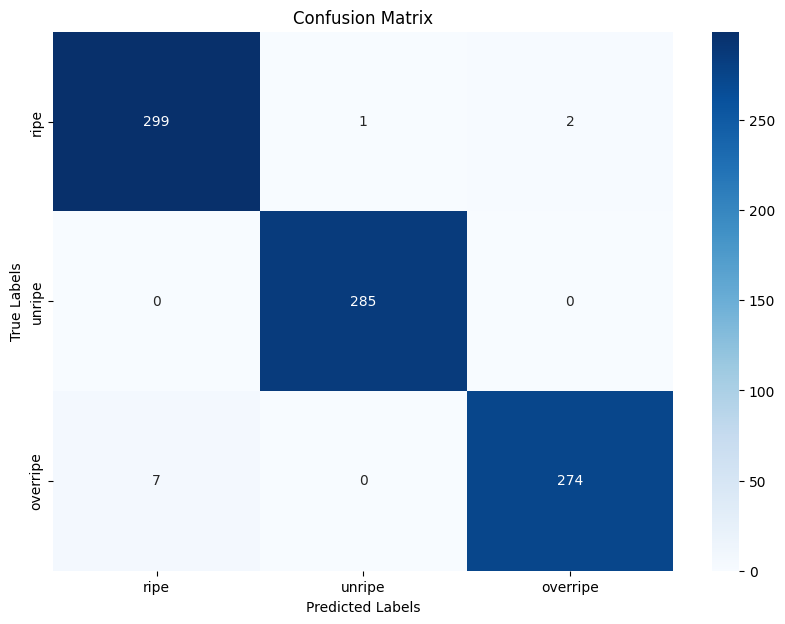

In [46]:
report = classification_report(true_labels, predictions, target_names=class_names)  # Replace `class_names` with your classes
print("Classification Report:\n", report)
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)  # Replace `class_names` with your class names
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
